### Chain Using LangGraph
In this section we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes

In [11]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)



In [12]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Binod"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Binod"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Binod

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Binod

I want to learn python programming language


### Chat Models

We can use the sequence of message as input with the chatmodels using LLM's and OPENAI.

In [21]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-120b")
result=llm.invoke(messages)

In [22]:
result

AIMessage(content='Great! Python is an excellent choice—its syntax is clean, the community is huge, and it’s used in everything from web development to data science, automation, AI, and more. Below is a **step‑by‑step roadmap** you can follow, plus resources, practice ideas, and tips to keep you motivated.\n\n---\n\n## 1️⃣ Get the Basics Right (Weeks 1‑2)\n\n| Topic | What to Learn | Quick Resources | Mini‑Exercise |\n|-------|--------------|----------------|---------------|\n| **Setup** | Install Python (latest stable version) and a code editor (VS\u202fCode, PyCharm Community, or even Jupyter Notebook). | • Official installer: <https://python.org/downloads> <br>• VS\u202fCode tutorial: <https://code.visualstudio.com/docs/python/python-tutorial> | Verify with `python --version` and run `print("Hello, world!")`. |\n| **Syntax & Data Types** | Variables, numbers, strings, booleans, basic operators, comments. | • Python.org tutorial: <https://docs.python.org/3/tutorial/introduction.html>

In [23]:
result.response_metadata

{'token_usage': {'completion_tokens': 3019,
  'prompt_tokens': 113,
  'total_tokens': 3132,
  'completion_time': 6.40590854,
  'prompt_time': 0.004697872,
  'queue_time': 0.048737538,
  'total_time': 6.410606412,
  'completion_tokens_details': {'reasoning_tokens': 35}},
 'model_name': 'openai/gpt-oss-120b',
 'system_fingerprint': 'fp_a28df4bce5',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the
natural language input and this will return an output that matches the tool's schema

In [16]:
def add(a: int, b: int) -> int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a+b

In [17]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10fa6d810>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10fa6e190>, model_name='groq/compound', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [27]:
# Binding tool with llm

llm_with_tools = llm.bind_tools([add])

tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 49 plus 22", name="Binod")])


In [28]:
tool_call.tool_calls

[]

# Using messages as state

In [47]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    messages: list[AnyMessage]

#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [53]:
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

### Reducers with add_messages

In [50]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Binod"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Binod')]

In [33]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [40]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='ca3a3b15-7e78-44f8-8e51-a6e44a97bbcb'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Binod', id='6fd36e11-c4ca-4370-a8dc-96f6f6225353'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='129662db-9784-4667-9ff9-f5ac50c50dd2')]

In [54]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

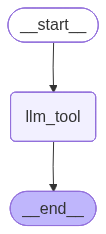

In [55]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [65]:
# invocation

messages=graph.invoke({"messages":"What is 324234 plus 65464"})

for message in messages["messages"]:
    message.pretty_print()


================================ Human Message =================================

What is 324234 plus 65464
================================== Ai Message ==================================
Tool Calls:
  add (fc_9dae6592-c69e-4207-b443-6b971464339e)
 Call ID: fc_9dae6592-c69e-4207-b443-6b971464339e
  Args:
    a: 324234
    b: 65464


In [58]:
tools=[add]

In [59]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

# Add nodes
builder.add_node("llm_tool",llm_tool)
builder.add_node("tools", ToolNode(tools))

# Add edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", END)

builder.add_edge("tools",END)


graph_builder = builder.compile()


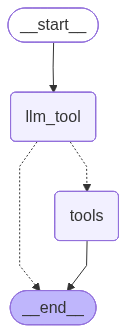

In [61]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [64]:
## invocation

messages=graph_builder.invoke({"messages":"What is 10343 plus 5432525"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 10343 plus 5432525
================================== Ai Message ==================================
Tool Calls:
  add (fc_3d37707e-6178-44e6-bada-3e282f7c3f83)
 Call ID: fc_3d37707e-6178-44e6-bada-3e282f7c3f83
  Args:
    a: 10343
    b: 5432525
================================= Tool Message =================================
Name: add

5442868


In [63]:

messages=graph_builder.invoke({"messages":"What is machine learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================

**Machine learning (ML)** is a sub‑field of artificial intelligence (AI) that focuses on developing algorithms and statistical models that enable computers to **learn from data** and make predictions or decisions without being explicitly programmed for each specific task.

---

## Core Idea
- **Learning from examples**: Instead of writing step‑by‑step rules, we feed a computer many examples (data) and let it infer patterns.
- **Generalization**: The model should perform well not only on the data it has seen but also on new, unseen data.

---

## How It Works (high‑level)

| Step | Description |
|------|-------------|
| **1. Data collection** | Gather raw data (images, text, sensor readings, etc.). |
| **2. Pre‑processing** | Clean, normalize, and transform data into a suitable format (e.g., feature e